# Library Setup

In [ ]:
!pip list | grep torch

torch                              2.5.1+cu121
torchaudio                         2.5.1+cu121
torchsummary                       1.5.1
torchvision                        0.20.1+cu121


In [ ]:
!pip install torch==2.0.1+cu117 torchvision==0.15.2+cu117 torchaudio==2.0.2+cu117 --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117
     ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.3/1.8 GB 170.3 MB/s eta 0:00:09
ERROR: Operation cancelled by user


In [ ]:
!pip install torch-scatter==2.1.2+pt20cu117 \
    torch-sparse==0.6.18+pt20cu117 \
    torch-cluster==1.6.3+pt20cu117 \
    torch-spline-conv==1.2.2+pt20cu117 \
    -f https://data.pyg.org/whl/torch-2.0.0+cu117.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu117.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 89.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.2/887.2 kB 53.3 MB/s eta 0:00:00


In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.6 MB/s eta 0:00:00


# Data Pipeline

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip -d ml-1m


--2024-11-18 16:04:06--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  25.7MB/s    in 0.2s    

2024-11-18 16:04:06 (25.7 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/ml-1m/
  inflating: ml-1m/ml-1m/movies.dat  
  inflating: ml-1m/ml-1m/ratings.dat  
  inflating: ml-1m/ml-1m/README      
  inflating: ml-1m/ml-1m/users.dat   


In [ ]:
!ls ml-1m/ml-1m

movies.dat  ratings.dat  README  users.dat


In [ ]:
import torch
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load and preprocess your dataset
ratings = pd.read_csv('ml-1m/ml-1m/ratings.dat', sep='::', header=None, engine='python',
                      names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='latin1')
movies = pd.read_csv('ml-1m/ml-1m/movies.dat', sep='::', header=None, engine='python',
                     names=['MovieID', 'Title', 'Genres'], encoding='latin1')
users = pd.read_csv('ml-1m/ml-1m/users.dat', sep='::', header=None, engine='python',
                    names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], encoding='latin1')

# Reindex UserID and MovieID
user_id_map = {id: idx for idx, id in enumerate(users['UserID'].unique())}
movie_id_map = {id: idx for idx, id in enumerate(movies['MovieID'].unique())}

ratings['UserID'] = ratings['UserID'].map(user_id_map)
ratings['MovieID'] = ratings['MovieID'].map(movie_id_map) + len(user_id_map)  # Offset movies

num_users = len(user_id_map)
num_movies = len(movie_id_map)
total_nodes = num_users + num_movies

# Create features and edge attributes
node_features = torch.randn(total_nodes, 7)  # Example: 7-dimensional node features
edge_index = torch.tensor(ratings[['UserID', 'MovieID']].values.T, dtype=torch.long)

edge_attr = torch.tensor(ratings['Rating'].values, dtype=torch.float32).unsqueeze(1)
target = (ratings['Rating'] >= 4).astype(int).values  # Binary target for rating >= 4

# Split dataset into train and validation
train_idx, val_idx = train_test_split(np.arange(edge_index.shape[1]), test_size=0.2, random_state=42)
train_data = Data(x=node_features, edge_index=edge_index[:, train_idx], edge_attr=edge_attr[train_idx],
                  y=torch.tensor(target[train_idx], dtype=torch.float32))
val_data = Data(x=node_features, edge_index=edge_index[:, val_idx], edge_attr=edge_attr[val_idx],
                y=torch.tensor(target[val_idx], dtype=torch.float32))

# Validate Data
print("Node Feature Matrix Shape:", node_features.shape)
print("Edge Index Shape:", edge_index.shape)
print("Max Edge Index:", edge_index.max().item())


Node Feature Matrix Shape: torch.Size([9923, 7])
Edge Index Shape: torch.Size([2, 1000209])
Max Edge Index: 9922


In [ ]:
print("Edge Attribute Shape:", edge_attr.shape)


Edge Attribute Shape: torch.Size([1000209, 1])


## Data exploration

Number of Users: 6040
Number of Movies: 3883
Number of Edges: 1000209
Node Feature Dimensions: 7
Edge Attribute Shape: torch.Size([1000209, 1])


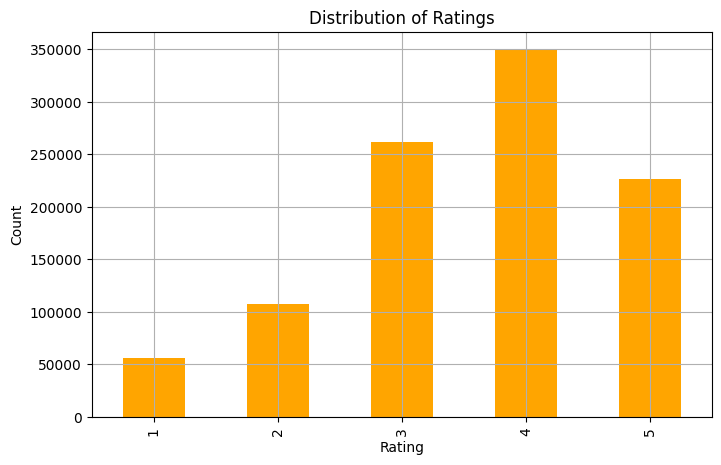

Sample Edges (User-Movie Interactions):
tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [7216, 6695, 6942, 9379, 8326, 7219, 7307, 8775, 6630, 6947]])


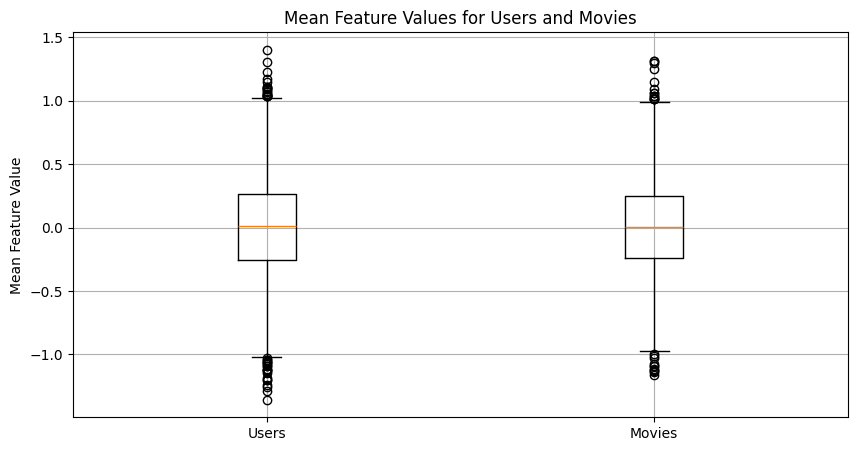

Sample Edge Attributes (Ratings):
tensor([[5.],
        [3.],
        [3.],
        [4.],
        [5.],
        [3.],
        [5.],
        [5.],
        [4.],
        [4.]])


In [ ]:
# Basic Dataset Stats
print(f"Number of Users: {num_users}")
print(f"Number of Movies: {num_movies}")
print(f"Number of Edges: {edge_index.shape[1]}")
print(f"Node Feature Dimensions: {node_features.shape[1]}")
print(f"Edge Attribute Shape: {edge_attr.shape}")

# Rating Distribution
ratings_distribution = ratings['Rating'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
ratings_distribution.plot(kind='bar', color='orange')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid()
plt.show()

# Sample Edges
print("Sample Edges (User-Movie Interactions):")
print(edge_index[:, :10])

# User and Movie Feature Distributions
user_features = node_features[:num_users]
movie_features = node_features[num_users:]

plt.figure(figsize=(10, 5))
plt.boxplot([user_features.mean(dim=1).numpy(), movie_features.mean(dim=1).numpy()],
            labels=["Users", "Movies"])
plt.title("Mean Feature Values for Users and Movies")
plt.ylabel("Mean Feature Value")
plt.grid()
plt.show()

# Edge Attributes
print("Sample Edge Attributes (Ratings):")
print(edge_attr[:10])


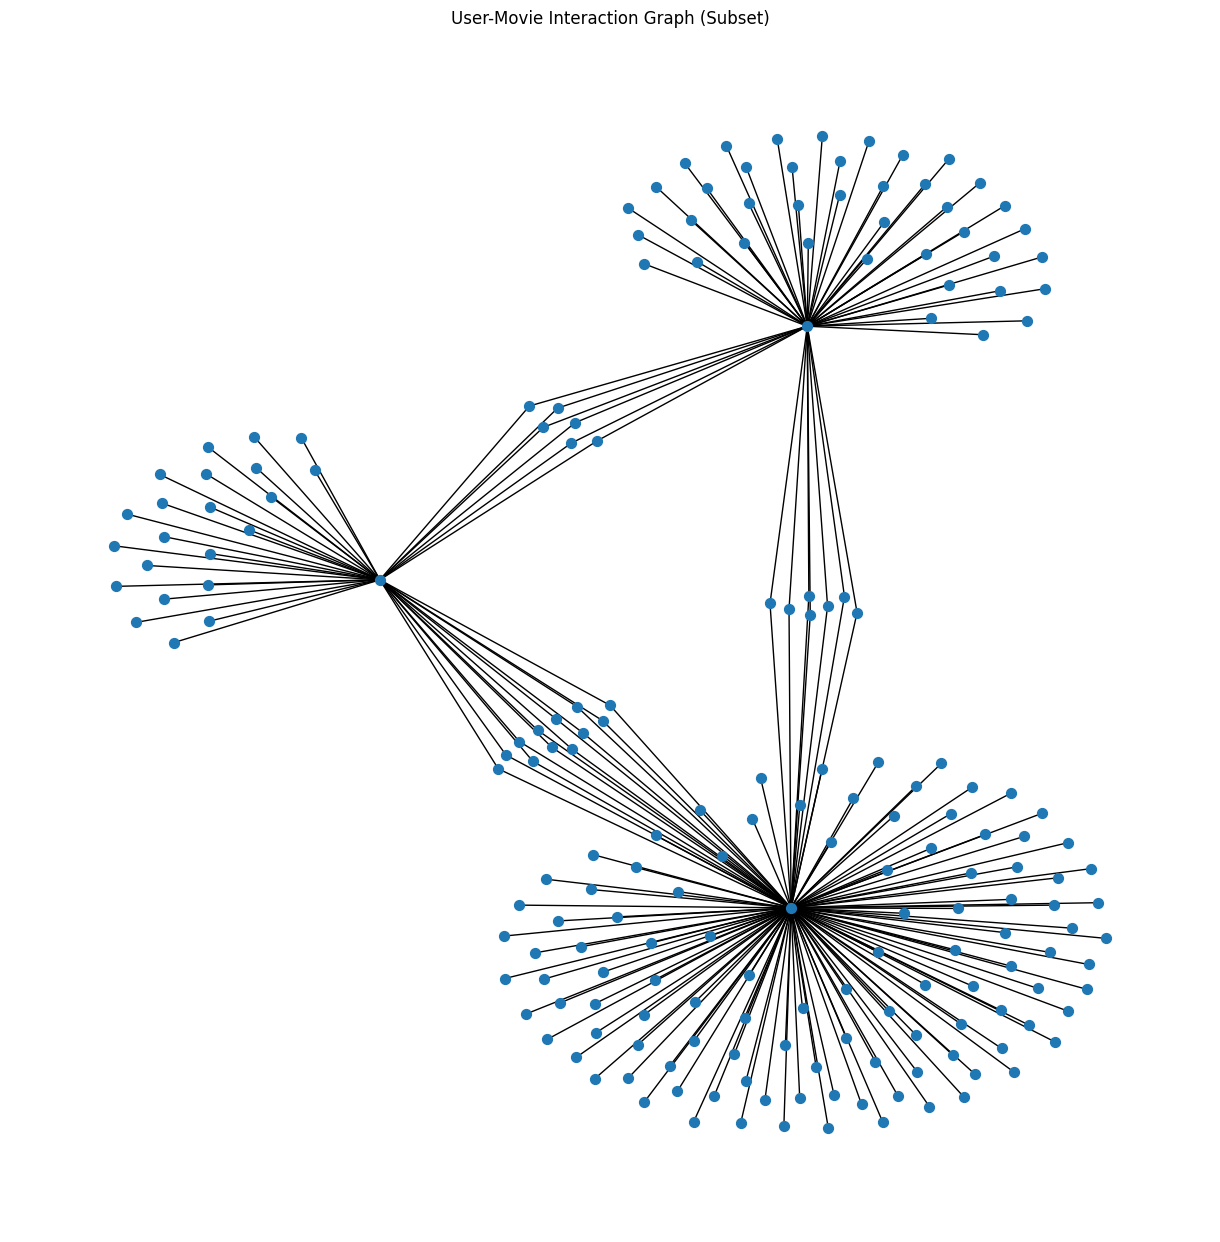

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()
edges = edge_index.T.numpy()
G.add_edges_from(edges)

# Draw a subgraph with a small subset for clarity
subgraph = G.subgraph(list(G.nodes)[:200])  # First 200 nodes
plt.figure(figsize=(12, 12))
nx.draw(subgraph, node_size=50, with_labels=False)
plt.title("User-Movie Interaction Graph (Subset)")
plt.show()


# Model Creation

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
# GAT-based Model
class GATEdgeClassifier(nn.Module):
    def __init__(self, hidden_dim=16):
        super(GATEdgeClassifier, self).__init__()
        self.gat1 = GATConv(-1, hidden_dim, heads=4, concat=True)
        self.gat2 = GATConv(hidden_dim * 4, hidden_dim, heads=1, concat=False)
        self.edge_predictor = nn.Sequential(
            nn.LazyLinear(hidden_dim),  # Includes edge_attr
            nn.ReLU(),
            nn.LazyLinear(1)
        )

    def forward(self, x, edge_index, edge_attr):
        x = F.relu(self.gat1(x, edge_index))
        x = F.relu(self.gat2(x, edge_index))
        edge_src = x[edge_index[0]]
        edge_tgt = x[edge_index[1]]
        edge_features = torch.cat([edge_src, edge_tgt, edge_attr], dim=1)
        return self.edge_predictor(edge_features).squeeze(-1)


In [ ]:
import torch.optim as optim
import torch.nn.init as init

# Initialize the model
model = GATEdgeClassifier(hidden_dim=16)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Print the model to ensure it looks correct
print(model)

# Define the loss function
criterion = nn.BCEWithLogitsLoss()


GATEdgeClassifier(
  (gat1): GATConv(-1, 16, heads=4)
  (gat2): GATConv(64, 16, heads=1)
  (edge_predictor): Sequential(
    (0): LazyLinear(in_features=0, out_features=16, bias=True)
    (1): ReLU()
    (2): LazyLinear(in_features=0, out_features=1, bias=True)
  )
)


# Training Loop

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store metrics for visualization
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    # Forward pass on training data
    train_output = model(train_data.x, train_data.edge_index, edge_attr=train_data.edge_attr).squeeze(-1)
    train_loss = criterion(train_output, train_data.y.float())
    train_losses.append(train_loss.item())

    # Backpropagation
    train_loss.backward()
    optimizer.step()

    # Compute training accuracy
    train_predictions = (torch.sigmoid(train_output) > 0.5).long()
    train_correct = (train_predictions == train_data.y.long()).sum().item()
    train_accuracy = train_correct / train_data.y.size(0)
    train_accuracies.append(train_accuracy)

    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        val_output = model(val_data.x, val_data.edge_index, edge_attr=val_data.edge_attr).squeeze(-1)
        val_loss = criterion(val_output, val_data.y.float())
        val_losses.append(val_loss.item())

        val_predictions = (torch.sigmoid(val_output) > 0.5).long()
        val_correct = (val_predictions == val_data.y.long()).sum().item()
        val_accuracy = val_correct / val_data.y.size(0)
        val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1, Train Loss: 0.6953, Train Accuracy: 0.4358, Val Loss: 0.6703, Val Accuracy: 0.5802
Epoch 2, Train Loss: 0.6705, Train Accuracy: 0.5791, Val Loss: 0.6489, Val Accuracy: 0.5757
Epoch 3, Train Loss: 0.6493, Train Accuracy: 0.5751, Val Loss: 0.6318, Val Accuracy: 0.5757
Epoch 4, Train Loss: 0.6322, Train Accuracy: 0.5750, Val Loss: 0.6187, Val Accuracy: 0.5781
Epoch 5, Train Loss: 0.6192, Train Accuracy: 0.5772, Val Loss: 0.6074, Val Accuracy: 0.6285
Epoch 6, Train Loss: 0.6076, Train Accuracy: 0.6278, Val Loss: 0.5984, Val Accuracy: 0.7476
Epoch 7, Train Loss: 0.5986, Train Accuracy: 0.7471, Val Loss: 0.5891, Val Accuracy: 0.7963
Epoch 8, Train Loss: 0.5892, Train Accuracy: 0.7969, Val Loss: 0.5762, Val Accuracy: 0.7385
Epoch 9, Train Loss: 0.5764, Train Accuracy: 0.7382, Val Loss: 0.5662, Val Accuracy: 0.6887
Epoch 10, Train Loss: 0.5665, Train Accuracy: 0.6881, Val Loss: 0.5555, Val Accuracy: 0.6932
Epoch 11, Train Loss: 0.5558, Train Accuracy: 0.6928, Val Loss: 0.5415, Val Acc

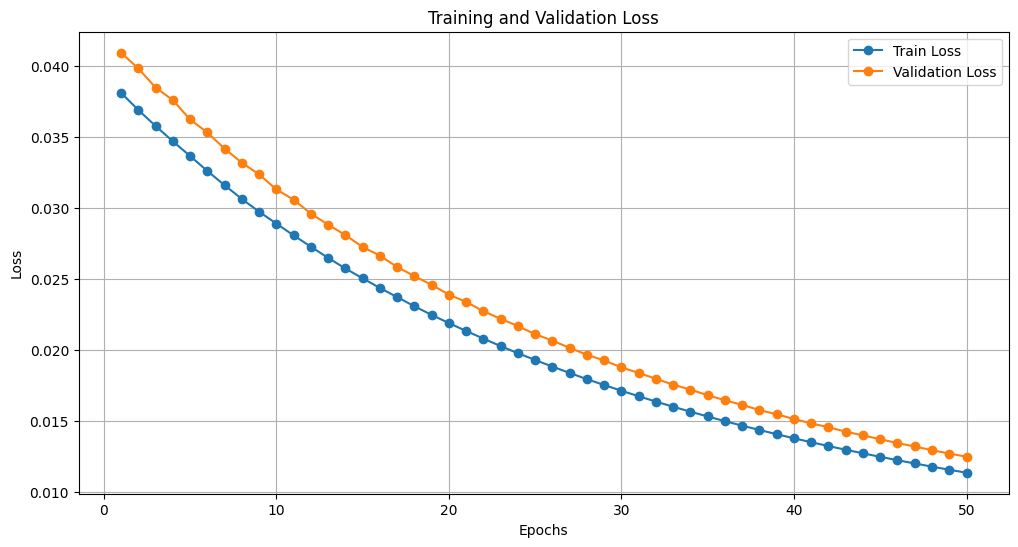

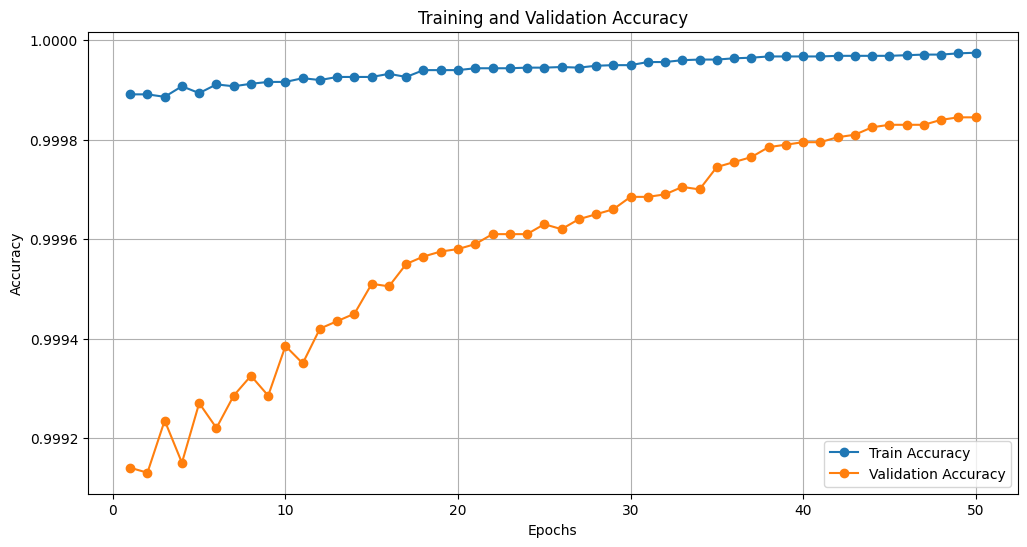

In [ ]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, 51), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, 51), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(range(1, 51), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, 51), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()



In [ ]:
# Switch the model to evaluation mode
model.eval()

# Select the dataset to inspect (e.g., validation data)
with torch.no_grad():
    # Forward pass on the validation dataset
    val_output = model(val_data.x, val_data.edge_index, edge_attr=val_data.edge_attr).squeeze(-1)

    # Compute predicted probabilities
    val_probs = torch.sigmoid(val_output)

    # Get binary predictions
    val_predictions = (val_probs > 0.5).long()

    # Get actual labels
    val_actuals = val_data.y.long()

    # Print a comparison for the first 20 samples
    for i in range(20):
        print(f"Sample {i + 1}:")
        print(f"  Predicted Probability: {val_probs[i].item():.4f}")
        print(f"  Predicted Label: {val_predictions[i].item()}")
        print(f"  Actual Label: {val_actuals[i].item()}")
        print("-" * 30)


Sample 1:
  Predicted Probability: 0.0097
  Predicted Label: 0
  Actual Label: 0
------------------------------
Sample 2:
  Predicted Probability: 0.9942
  Predicted Label: 1
  Actual Label: 1
------------------------------
Sample 3:
  Predicted Probability: 0.8813
  Predicted Label: 1
  Actual Label: 1
------------------------------
Sample 4:
  Predicted Probability: 0.9214
  Predicted Label: 1
  Actual Label: 1
------------------------------
Sample 5:
  Predicted Probability: 0.0023
  Predicted Label: 0
  Actual Label: 0
------------------------------
Sample 6:
  Predicted Probability: 0.8456
  Predicted Label: 1
  Actual Label: 1
------------------------------
Sample 7:
  Predicted Probability: 0.9847
  Predicted Label: 1
  Actual Label: 1
------------------------------
Sample 8:
  Predicted Probability: 0.5769
  Predicted Label: 1
  Actual Label: 0
------------------------------
Sample 9:
  Predicted Probability: 0.0011
  Predicted Label: 0
  Actual Label: 0
-----------------------

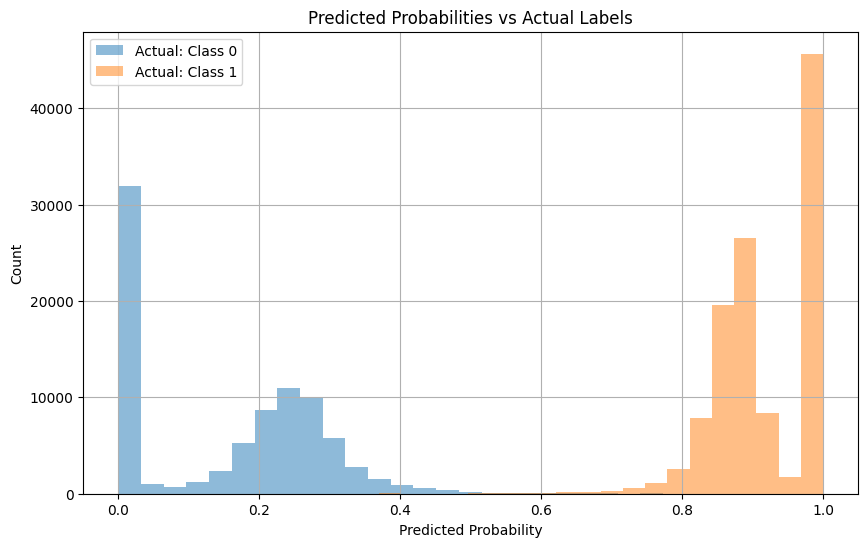

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of probabilities for both classes
plt.figure(figsize=(10, 6))
plt.hist(val_probs[val_actuals == 0].cpu(), bins=30, alpha=0.5, label='Actual: Class 0')
plt.hist(val_probs[val_actuals == 1].cpu(), bins=30, alpha=0.5, label='Actual: Class 1')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Predicted Probabilities vs Actual Labels')
plt.legend()
plt.grid()
plt.show()


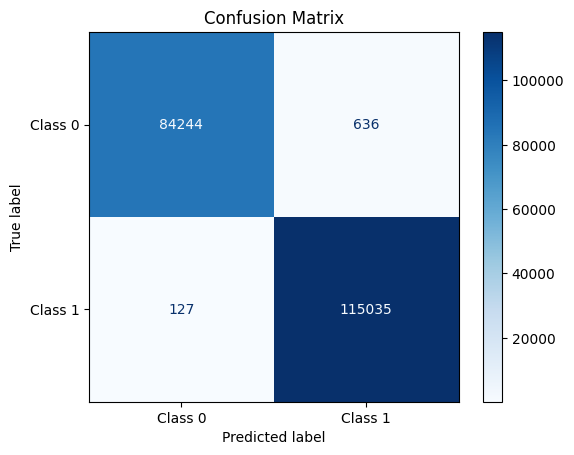

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(val_actuals.cpu(), val_predictions.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])

# Plot confusion matrix
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import random

# Number of samples to display
num_samples = 10

# Convert edge data and labels to NumPy for easier handling
edge_index = train_data.edge_index.cpu().numpy()
edge_attr = train_data.edge_attr.cpu().numpy()
labels = train_data.y.cpu().numpy()

# Randomly select edges to inspect
sample_indices = random.sample(range(edge_index.shape[1]), num_samples)

print("Sample Observations from Training Data:")
print("=" * 50)
for i, idx in enumerate(sample_indices):
    source_node = edge_index[0, idx]
    target_node = edge_index[1, idx]
    edge_features = edge_attr[idx]
    label = labels[idx]

    print(f"Sample {i + 1}:")
    print(f"  Source Node ID: {source_node}")
    print(f"  Target Node ID: {target_node}")
    print(f"  Edge Features: {edge_features}")
    print(f"  Label: {label}")
    print("-" * 50)

# Optional: Display node features for a couple of nodes
node_features = train_data.x.cpu().numpy()

print("\nSample Node Features:")
print("=" * 50)
for i in range(5):  # Display features for first 5 nodes
    print(f"Node {i}: {node_features[i]}")
    print("-" * 50)


Sample Observations from Training Data:
Sample 1:
  Source Node ID: 3100
  Target Node ID: 6290
  Edge Features: [4.]
  Label: 1.0
--------------------------------------------------
Sample 2:
  Source Node ID: 2236
  Target Node ID: 8116
  Edge Features: [3.]
  Label: 0.0
--------------------------------------------------
Sample 3:
  Source Node ID: 3890
  Target Node ID: 6695
  Edge Features: [4.]
  Label: 1.0
--------------------------------------------------
Sample 4:
  Source Node ID: 1302
  Target Node ID: 9579
  Edge Features: [4.]
  Label: 1.0
--------------------------------------------------
Sample 5:
  Source Node ID: 2093
  Target Node ID: 7121
  Edge Features: [2.]
  Label: 0.0
--------------------------------------------------
Sample 6:
  Source Node ID: 3498
  Target Node ID: 9332
  Edge Features: [1.]
  Label: 0.0
--------------------------------------------------
Sample 7:
  Source Node ID: 4492
  Target Node ID: 6926
  Edge Features: [4.]
  Label: 1.0
-----------------

In [ ]:
print(ratings.head())
print(movies.head())
print(users.head())


   UserID  MovieID  Rating  Timestamp
0       0     7216       5  978300760
1       0     6695       3  978302109
2       0     6942       3  978301968
3       0     9379       4  978300275
4       0     8326       5  978824291
   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy
   UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455


# Compairsion to Traditional Machine Learning Methods

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Prepare user features
users['UserID'] = users['UserID'] - 1  # Zero-indexed User IDs
user_features = pd.get_dummies(users.set_index('UserID')[['Gender', 'Age', 'Occupation']], drop_first=True).reindex(
    range(users['UserID'].max() + 1), fill_value=0).values

# Prepare movie features
movies['MovieID'] = movies['MovieID'] - 1  # Zero-indexed Movie IDs
movie_features = pd.get_dummies(movies.set_index('MovieID')['Genres'].str.get_dummies('|')).reindex(
    range(movies['MovieID'].max() + 1), fill_value=0).values

# Adjust the number of users and movies
num_users = user_features.shape[0]
num_movies = movie_features.shape[0]

# Create the combined features array
combined_features = np.zeros((num_users + num_movies, user_features.shape[1] + movie_features.shape[1]))

# Assign user features
combined_features[:num_users, :user_features.shape[1]] = user_features

# Assign movie features
combined_features[num_users:, user_features.shape[1]:] = movie_features

# Ensure ratings are zero-indexed and consistent with feature matrix size
ratings['UserID'] = ratings['UserID'] - 1  # Zero-indexed User IDs
ratings['MovieID'] = ratings['MovieID'] - 1  # Zero-indexed Movie IDs

# Check for valid IDs
if ratings['UserID'].max() >= num_users or ratings['MovieID'].max() >= num_movies:
    raise ValueError("Mismatch between ratings and feature matrix dimensions.")

# Create edge-based data
edge_data = pd.DataFrame({
    'UserID': ratings['UserID'],
    'MovieID': ratings['MovieID'] + num_users,  # Offset for movie IDs
    'Rating': (ratings['Rating'] >= 4).astype(int)  # Binary target
})

# Ensure no indices exceed the bounds of the combined_features matrix
if edge_data['UserID'].max() >= combined_features.shape[0] or edge_data['MovieID'].max() >= combined_features.shape[0]:
    raise IndexError("Edge indices exceed bounds of combined_features.")

# Combine features for edges
features = np.hstack((combined_features[edge_data['UserID']], combined_features[edge_data['MovieID']]))

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, edge_data['Rating'], test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




IndexError: index 13250 is out of bounds for axis 0 with size 9986